In [16]:
### Import required libraries
import pandas as pd
import seaborn as sns
from sqlite3 import connect
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

### Required constants
DB_PATH = "dataset/dataset.db"
TABLE_NAME = "prj1"

### One way ANOVA

In [17]:
### Connect to sqlite3 database
connection = connect(DB_PATH)

### Create pandas dataframe for analysis
query = "SELECT * FROM " + TABLE_NAME
df = pd.read_sql(query, connection)
df

,index,Less than HS,45
0,0,Less than HS,26.0
1,1,Less than HS,43.8
2,2,Less than HS,34.4
3,3,Less than HS,76.2
4,4,Less than HS,0.2
...,...,...,...
1166,1166,Graduate,52.7
1167,1167,Graduate,59.8
1168,1168,Graduate,54.1
1169,1169,Graduate,39.9


In [18]:
df.rename(columns = {"Less than HS": "Education Level", "45": "Salary (x1000)"}, inplace = True)
df.drop(columns = ["index"], inplace = True)

temp_frames = []
for idx, edu_lvl in enumerate(df['Education Level'].unique()):
    temp_frames.append(df[df['Education Level'] == edu_lvl].drop(columns = ['Education Level']).rename(columns = {"Salary (x1000)": edu_lvl}))

temp_df = pd.concat(temp_frames).reset_index(drop = True) 

for frame in temp_frames:
    frame.fillna(frame.median(), inplace = True)

temp_df = pd.concat(temp_frames).reset_index(drop = True)
df = pd.melt(temp_df).dropna().reset_index(drop = True)
df

,variable,value
0,Less than HS,26.0
1,Less than HS,43.8
2,Less than HS,34.4
3,Less than HS,76.2
4,Less than HS,0.2
...,...,...
1166,Graduate,52.7
1167,Graduate,59.8
1168,Graduate,54.1
1169,Graduate,39.9


<AxesSubplot:>

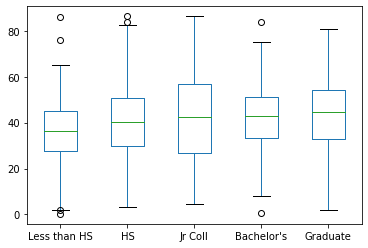

In [19]:
### Visualize 
temp_df.boxplot(grid = False)

In [20]:
### ANOVA
model = ols('value ~ C(variable)', data = df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.583
Date:                Mon, 21 Nov 2022   Prob (F-statistic):            0.00112
Time:                        14:46:28   Log-Likelihood:                -4830.6
No. Observations:                1171   AIC:                             9671.
Df Residuals:                    1166   BIC:                             9697.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      42.1342      0.943     44.663      0.000      40.283      43.985
C(variable)[T.Graduate]         1.4936      1.531      0.976      0.329      -1.509       4.497
C(variable)[T.HS]              -2.0085      1.141     -1.760      0.079      -4.248       0.231
C(variable)[T.Jr Coll]         -1.1151      1.792     -0.622      0.534      -4.631       2.401
C(variable)[T.Less than HS]    -5.6075      1.663     -3.371      0.001      -8.871      -2.344
==============================================================================
Omnibus:                        0.362   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.834   Jarque-Bera (JB):                0.431
Skew:                           0.034   Prob(JB):                        0.806
Kurtosis:                       2.935   Cond. No.                         6.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
anova_table = sm.stats.anova_lm(model, typ = 2)
esq_sm = anova_table['sum_sq'][0] / (anova_table['sum_sq'][0] + anova_table['sum_sq'][1])
anova_table['EtaSq'] = [esq_sm, 'NaN']
anova_table

,sum_sq,df,F,PR(>F),EtaSq
C(variable),4128.063342,4.0,4.583416,0.001124,0.01548
Residual,262540.110377,1166.0,NaN,NaN,NaN


In [22]:
### Multiple pairwise comparisons
pair_t = model.t_test_pairwise('C(variable)')
pair_t.result_frame

,coef,std err,t,P>|t|,Conf. Int. Low,Conf. Int. Upp.,pvalue-hs,reject-hs
Graduate-Bachelor's,1.493552,1.530568,0.975816,0.329358,-1.509422,4.496527,0.698372,False
HS-Bachelor's,-2.008549,1.141209,-1.760018,0.078667,-4.247602,0.230505,0.336130,False
Jr Coll-Bachelor's,-1.115118,1.791994,-0.622278,0.533881,-4.631010,2.400775,0.782733,False
Less than HS-Bachelor's,-5.607523,1.663229,-3.371468,0.000772,-8.870780,-2.344266,0.006928,True
HS-Graduate,-3.502101,1.365669,-2.564385,0.010460,-6.181544,-0.822658,0.080681,False
Jr Coll-Graduate,-2.608670,1.942661,-1.342833,0.179587,-6.420173,1.202833,0.546968,False
Less than HS-Graduate,-7.101075,1.824561,-3.891936,0.000105,-10.680865,-3.521285,0.001050,True
Jr Coll-HS,0.893431,1.653377,0.540368,0.589047,-2.350495,4.137358,0.782733,False
Less than HS-HS,-3.598974,1.512860,-2.378921,0.017524,-6.567206,-0.630742,0.116402,False
Less than HS-Jr Coll,-4.492405,2.048811,-2.192689,0.028527,-8.512174,-0.472637,0.159409,False


In [24]:
### Tukey HSD
mc = sm.stats.multicomp.MultiComparison(df['value'], df['variable'])
mc_results = mc.tukeyhsd()
print(mc_results)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1      group2    meandiff p-adj   lower    upper  reject
---------------------------------------------------------------
Bachelor's     Graduate   1.4936 0.8662   -2.688  5.6751  False
Bachelor's           HS  -2.0085 0.3977  -5.1264  1.1093  False
Bachelor's      Jr Coll  -1.1151 0.9715  -6.0109  3.7807  False
Bachelor's Less than HS  -5.6075 0.0069 -10.1515 -1.0635   True
  Graduate           HS  -3.5021 0.0777  -7.2332   0.229  False
  Graduate      Jr Coll  -2.6087 0.6644  -7.9161  2.6988  False
  Graduate Less than HS  -7.1011  0.001 -12.0859 -2.1163   True
        HS      Jr Coll   0.8934 0.9831  -3.6237  5.4105  False
        HS Less than HS   -3.599 0.1218  -7.7322  0.5342  False
   Jr Coll Less than HS  -4.4924 0.1831 -10.0899   1.105  False
---------------------------------------------------------------


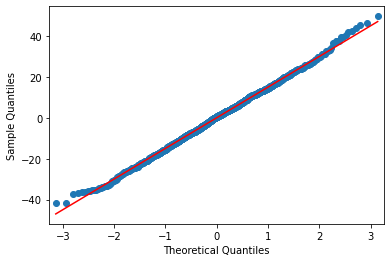

In [25]:
### Assumption Checks

#1) Normality using Q-Q plot
res = model.resid
fig = sm.qqplot(res, line = 's')

0.3711097240447998


C:\Users\Jainam\miniconda3\envs\personal\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


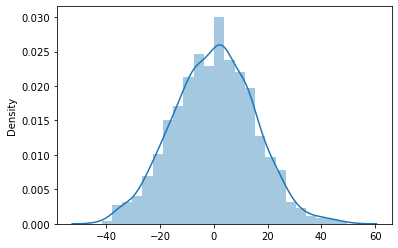

In [26]:
#2) Normality using Histogram Plot
sns.distplot(res, bins = 'auto', hist = True)
w, pvalue = stats.shapiro(model.resid)
print(pvalue)

In [33]:
# Homogeneity using Bartlett & Levene Tests
w, pvalue = stats.bartlett(df['value'][df['variable'] == 'Less than HS'],
                          df['value'][df['variable'] == 'HS'],
                           df['value'][df['variable'] == 'Jr Coll'],
                          df['value'][df['variable'] == "Bachelor's"],
                          df['value'][df['variable'] == 'Graduate'])

print("Bartlett's Test:\tw:{:7.4f}, pvalue:{:7.4f}".format(w, pvalue))

w, pvalue = stats.levene(temp_df['Less than HS'].dropna(), temp_df['HS'].dropna(), temp_df['Jr Coll'].dropna(), temp_df["Bachelor's"].dropna(), temp_df['Graduate'].dropna())
print("Levene's Test:\t\tw:{:7.4f}, pvalue:{:7.4f}".format(w, pvalue))

Bartlett's Test:	w:17.5776, pvalue: 0.0015
Levene's Test:		w: 5.4545, pvalue: 0.0002
